In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import hashlib
import pickle, time, os

import matplotlib

import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
sns.set(style='whitegrid', font='STIXGeneral', font_scale=1.25)


import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Whether to use GPU or not
tf.logging.set_verbosity(tf.logging.ERROR)
tfconfig = tf.ConfigProto()
tfconfig.gpu_options.allow_growth=True

import entropy, loaddata, mc_entropy
import loaddata


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
def loadresults(sess, data, basedir, sfx, verbose=0, rerun=False, store_batch=False):
    Xbatch, saver = None, None
    vals = {}
    
    for fname in os.listdir(basedir):
        if not fname.endswith(sfx):
            continue

        fullfname = os.path.join(basedir, fname, 'data')
        if verbose > 0:
            print(fullfname)
        with open(fullfname, 'rb') as f:
            try:    
                cfg, saved_data = pickle.load(f)
            except: 
                print("Error loading pickle file") ; continue

        if not len(vals): # First time through this loop
            print("Doing", basedir, sfx)

        
        runtype = cfg['runtype']
        if cfg['runtype'] != data['runtype']:
            raise Exception('Wrong dataset')

        sqmode = cfg['objective'] if 'objective' in cfg else ('sq' if cfg['squaredIB'] else 'reg') # !!!
        beta   = saved_data[0]['beta']
        method = saved_data[0]['mode'] if 'mode' in saved_data[0] else saved_data[0]['method'] #!!! # mode indicates 'ce' vs 'nlIB' vs 'VIB'
        backtrack = cfg['patience'] if 'patience' in cfg else cfg['early_stopping_patience'] # !!!
        
        for trntstmode in ['trn','tst']:
            val_dict = {'beta': beta}
            # sess, saver = None, None

            #for lrow in saved_data[-n_average_epoch-backtrack:-backtrack]:
            if len(saved_data) < backtrack:
                continue
                
            lrow = saved_data[-backtrack]
                
            var   = lrow['noisevar']
            l     = lrow[trntstmode]
            epoch = lrow['epoch']

            epoch_fname = '%s/%s/tf_model-%d' % (basedir, fname, epoch)
            epoch_fname_full = epoch_fname+'.data-00000-of-00001'

            if not os.path.exists(epoch_fname_full):
                print("ERROR: Cant find %s" % epoch_fname_full)
                print(backtrack, epoch, len(saved_data), saved_data[-1]['epoch'])
                continue

            h = hashlib.md5(open(epoch_fname_full,'rb').read()).hexdigest() + '-' + trntstmode
            cache_dir = '.mc_entropy_cache'
            if not os.path.exists(cache_dir):
                os.makedirs(cache_dir)

            cachefile_exists =  os.path.exists(cache_dir + '/'+h)
            if not rerun and cachefile_exists: # cache calculations
                with open(cache_dir + '/'+h, 'rb') as f:
                    l = pickle.load(f)
            else:
                if cachefile_exists:
                    os.remove(cache_dir + '/'+h)

                if saver is None:
                    saver = tf.train.import_meta_graph(tf.train.latest_checkpoint('%s/%s' % (basedir, fname))+'.meta')

                saver.restore(sess, epoch_fname)

                if Xbatch is None:
                    permutation  = np.random.permutation(len(data[trntstmode+'_X']))
                    Xbatch = data[trntstmode+'_X'][permutation[:2000]]
                    Ybatch = np.argmax(data[trntstmode+'_Y'][permutation[:2000]],axis=1)

                mx          = sess.run( 'noisy_ib_layer/RawInput:0' , feed_dict={'X:0':Xbatch})
                
                n, d        = mx.shape
                mcH         = mc_entropy.get_mc_entropy(mx, var)
                hCond       = entropy.gaussian_entropy_np(d, var)
                l['beta']   = beta
                l['Ixt_mc'] = mcH - hCond
                l['noisevar'] = var
                
                if store_batch:
                    l['hidden_acts'] = sess.run( 'noisy_ib_layer/RawInput:0' , feed_dict={'X:0':data[trntstmode+'_X']})
                    l['pred_y']      = data[trntstmode+'_Y']
                    if data['err'] != 'mse':
                        l['pred_y'] = np.argmax(data[trntstmode+'_Y'],axis=1)

                with open(cache_dir + '/'+h, 'wb') as f:
                    pickle.dump(l, f)

            val_dict = l
            #for k in ['Ixt','Ixt_lb','Iyt','Ixt_mc','ce']:
            #    if k not in val_dict:
            #        val_dict[k]=0.
            #    val_dict[k] += l[k]/np.abs(n_average_epoch)

            if method == 'ce':
                val_dict['Ixt_mc'] = np.nan
                
            val_dict['err'] = data['err']
                
            if data['err'] == 'mse':
                hcond = 0.5*(np.log(2*np.pi*val_dict['ce']) + 1)
                l['Iyt'] = data[trntstmode+'_entropyY'] - hcond
                
            if verbose > 1:
                print('%s %s beta: %4g ce: %0.3f Ixt: %0.3f-%0.3f (%0.3f) Iyt: %0.3f' % 
                      (trntstmode, sqmode, beta, val_dict['ce'], val_dict['Ixt_lb'], val_dict['Ixt'], val_dict['Ixt_mc'], val_dict['Iyt']))

            k = (trntstmode, method, sqmode)
            if k not in vals:
                vals[k] = []
            vals[k].append(val_dict)
            
        if verbose > 1:
            print()
            
    del Xbatch, saver
            
    return vals



def plotresults(baseline, run_results, axes, methods=None, sqmodes=None, plotmode=0):
    
    def sort_and_interp(newx, oldx, oldy):
        ix = np.argsort(oldx)
        oldx = np.array(oldx)[ix]
        oldy = np.array(oldy)[ix]
        return np.interp(newx, oldx, oldy, left=np.nan, right=np.nan)
    
    colordict={('nlIB','reg'):'blue', ('nlIB','sq'):'blue', 
               ('VIB','reg'):'red', ('VIB','sq'):'red',
               ('VIBraw','reg'):'orange', ('VIBraw','sq'):'orange' }
    
    baselineIyt = {}


    svals = {}
    minX = min([entry['Ixt_mc']  for results in run_results.values() for run in results for entry in run])
    maxX = max([entry['Ixt_mc']  for results in run_results.values() for run in results for entry in run])
    newx     = np.linspace(minX, maxX, 30, endpoint=True) 
    
    for k, results in run_results.items():
        trntstmode, method, sqmode = k

        if not len(results):                              continue
        if sqmodes is not None and sqmode not in sqmodes: continue
        if methods is not None and method not in methods: continue
            
        if (trntstmode, 'ce', sqmode) in baseline:
            baselineIyt[trntstmode] = np.mean([r['Iyt'] for r in baseline[(trntstmode, 'ce', sqmode)]])
            
        plt.sca(axes[0 if trntstmode == 'trn' else 1])
        

        methodcolor = colordict[(method,sqmode)]
        linestyle   = '-' if sqmode == 'sq' else ':'
        label       = method # method + " (%s)" % sqmode
                
        resamp_y = []
        for run in results:
            xs = [entry['Ixt_mc'] for entry in run]
            ys = [entry['Iyt']    for entry in run]
            resamp_y.append(sort_and_interp(newx, xs, ys))
        resamp_y = np.array(resamp_y)
        mean_y   = np.nanmean(resamp_y, axis=0) 
        # standard error of the mean
        stderr   = np.nanstd(resamp_y, axis=0) / np.sqrt(np.sum(~np.isnan(resamp_y), axis=0)) 
        #errorbars = 1.96*stderr # 95% CI of the mean
        errorbars = stderr
        
        if plotmode == 0:
            plt.plot(newx, mean_y, ls=linestyle, color=methodcolor, label=label)
            if resamp_y.shape[0] > 1:
                plt.fill_between(newx, mean_y - errorbars, mean_y + errorbars, color=methodcolor, alpha=0.3)
        else:
            for run in results:
                cX = np.array([entry['Ixt_mc'] for entry in run])
                cY = np.array([entry['Iyt']    for entry in run])
                ix = np.argsort(cX)
                plt.plot(cX[ix], cY[ix], marker='x', ls=linestyle, color=methodcolor, label=label)

        svals[k] = mean_y
        
        
    for trntstmode in ['trn','tst']:
        
        for sqmode in ['reg','sq']:
            k1, k2 = (trntstmode,'nlIB',sqmode), (trntstmode,'VIB',sqmode)
            if k1 in svals and k2 in svals:
                perfdiff  = svals[k1]-svals[k2]
                perfratio = svals[k1]/svals[k2]
                if not np.all(np.isnan(perfratio)):
                    print('max rel improvment %s %s: %g at %g' % (trntstmode, sqmode, np.nanmax(perfratio), newx[np.nanargmax(perfratio)]))
                if not np.all(np.isnan(perfdiff)):
                    print('max abs improvment %s %s: %g at %g' % (trntstmode, sqmode, np.nanmax(perfdiff) , newx[np.nanargmax(perfdiff)]))
                
        plt.sca(axes[0 if trntstmode == 'trn' else 1])
                
        if trntstmode in baselineIyt:
            err = 'MSE' if runtype == 'Housing' else 'CE'
            plt.hlines(baselineIyt[trntstmode],  plt.xlim()[0], plt.xlim()[1], 
                       linestyles=':', label=err + ' only')
        
        plt.xlabel('$I(X;M)$')
        if trntstmode == 'trn':
            plt.ylabel('$I(Y;M)$')
        plt.legend(loc='lower right')
        plt.title(runtype + ' - ' + {'tst':'Testing', 'trn':'Training'}[trntstmode])

        plt.ylim([0, plt.ylim()[1]*1.1])
        plt.xlim([0, plt.xlim()[1]])
            
        plt.xlim([0, 4])
        #if runtype.endswith( 'MNIST' ):
        #    plt.ylim([0, 2.5])
            
        xlims = plt.xlim()
        ylims = plt.ylim()
        plt.plot([0, 5], [0, 5], '--k')
        plt.xlim(xlims)
        plt.ylim(ylims)
            

    #plt.tight_layout()
    
    return axes


results6/v1-256-p50/MNIST
Doing results6/v1-256-p50/MNIST basemodel
Doing results6/v1-256-p50/MNIST run0
ERROR: Cant find results6/v1-256-p50/MNIST/results-VIB-0.08612-reg--nptrun0/tf_model-32.data-00000-of-00001
50 32 82 81
ERROR: Cant find results6/v1-256-p50/MNIST/results-VIB-0.08612-reg--nptrun0/tf_model-32.data-00000-of-00001
50 32 82 81
ERROR: Cant find results6/v1-256-p50/MNIST/results-VIB-0.14546-sq--nptrun0/tf_model-24.data-00000-of-00001
50 24 74 73
ERROR: Cant find results6/v1-256-p50/MNIST/results-VIB-0.14546-sq--nptrun0/tf_model-24.data-00000-of-00001
50 24 74 73
max rel improvment trn sq: 1.03965 at 0.592719
max abs improvment trn sq: 0.0424018 at 1.45131
max rel improvment tst sq: 1.07531 at 0.211123
max abs improvment tst sq: 0.0273402 at 0.974315
saving outputpdf/v3/MNIST-v1-256-p50-sq.pdf


/home/artemy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:170: RuntimeWarning: Mean of empty slice
/home/artemy/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/artemy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:170: RuntimeWarning: Mean of empty slice
/home/artemy/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


max rel improvment trn reg: 1.04341 at 2.4053
max abs improvment trn reg: 0.0924551 at 2.4053
max rel improvment tst reg: 1.02273 at 2.5007
max abs improvment tst reg: 0.0469465 at 2.5007
saving outputpdf/v3/MNIST-v1-256-p50-reg.pdf
results6/v1-256-p50/FashionMNIST doesnt exist
results6/v1-256-p50/Housing doesnt exist


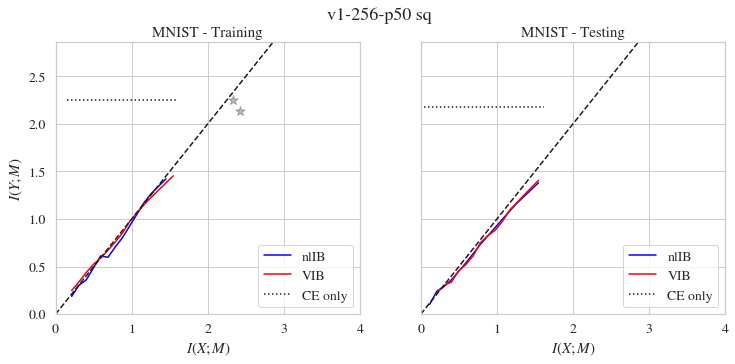

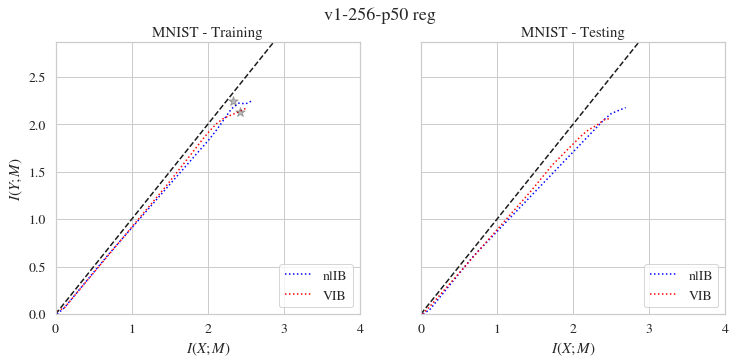

In [12]:
plotmode = 0
samefig  = False
maxruns  = 5
resultsdir, dirfilters = 'savedata200/' , ['e10n10',]
#resultsdir = 'results2/'
# resultsdir = 'test1/' # test4-500/'
figdir     = 'outputpdf/v3'
resultsdir, dirfilters = 'saved_results5/', None
resultsdir, dirfilters = './', 'test8'
resultsdir, dirfilters = 'results2/', ['v7nptV2',]#  None # 'v5' # 'v2'
resultsdir, dirfilters = 'results3/', [ 'v8-256-',] # 'v8-128',    # None # 
resultsdir, dirfilters = 'results6/', None # 


# 'results3/v8-64-p50' # Good runs



#resultsdir, dirfilter = './', 'test5'

# v1 is 128 batch
# v2 is 500 batch
# v3 is  64 batch
    

run_results = {}
baselines   = {}
    
for runtype in [ 'MNIST','FashionMNIST','Housing', ]:
    data = loaddata.load_data(runtype, validation='True')
    
    pltaxes = {}
    for cdir in sorted(os.listdir(resultsdir)):
        
        if dirfilters is not None and not any(cdir.startswith(f) for f in dirfilters):
            continue
        #if cdir != 'test14-500':
        #    continue
        #if cdir != 'test50-128':
        #    continue
            
        basedir = os.path.join(resultsdir, cdir, runtype)
        if not os.path.exists(basedir):
            print(basedir, 'doesnt exist')
            continue
        print(basedir)

        tf.reset_default_graph()
        run_results[runtype] = {}
        with tf.Session(config=tfconfig) as sess:
            baselines[runtype] = loadresults(sess, data, basedir,'basemodel', store_batch=True)
            for run in range(maxruns):
                store_batch = run == 0
                res = loadresults(sess, data, basedir, 'run'+str(run), store_batch=store_batch)
                for k, v in res.items():
                    if k not in run_results[runtype]:
                        run_results[runtype][k] = []
                    run_results[runtype][k].append(v)
                
        for sqmode in ['sq','reg',]:# 'reg',]:
            if ('trn','nlIB',sqmode) not in run_results[runtype]:
                continue
                
            if sqmode not in pltaxes or not samefig:
                # Share a X axis with each column of subplots
                _, pltaxes[sqmode] = plt.subplots(1, 2, figsize=(12,5), sharey='row')

            axes = plotresults(baselines[runtype], run_results[runtype], pltaxes[sqmode],
                               methods=['nlIB','VIB'], sqmodes=[sqmode,],
                               plotmode=plotmode)
            if runtype == 'MNIST':
                plt.sca(axes[0])
                plt.scatter(2.4265032933366513, 2.134885 , 100, 'k', marker='*', zorder=5, alpha=.3)
                plt.scatter(2.3313439713132595, 2.2476184, 100, 'k', marker='*', zorder=5, alpha=.3)
            if True and figdir is not None:
                if not os.path.exists(figdir):
                    os.makedirs(figdir)
                pdfname = '%s/%s-%s-%s.pdf' % (figdir, runtype, cdir, sqmode)
                print('saving %s' % pdfname)
                plt.savefig(pdfname, bbox_inches='tight')
            # else:
            plt.suptitle(cdir  + ' ' + sqmode)
            #asdfsdf


In [ ]:

sns.set_style("whitegrid")
do_pca = True
runtype = 'Housing'
if False:
    basedir = 'savedata-d2/MNIST/'
    data = loaddata.load_data('MNIST', validation='True')

    tf.reset_default_graph()
    run_results = {}
    with tf.Session(config=tfconfig) as sess:
        baseline = loadresults(sess, data, basedir, 'basemodel', store_batch=True)
        res      = loadresults(sess, data, basedir, 'run0'     , store_batch=True)

    todo = [(baseline[('trn','ce','sq')], 'Baseline'), (res[('trn','VIB','sq')], 'VIB'), (res[('trn','nlIB','sq')], 'nlIB')]
else:
    trntstmode = 'tst'
    todo = [# (baselines[runtype][(trntstmode,'ce','sq')], 'Baseline'), 
            (run_results[runtype][(trntstmode,'VIB','sq')][0], 'VIB'), 
            (run_results[runtype][(trntstmode,'nlIB','sq')][0], 'nlIB')]
    
plt.figure(figsize=(15,4.5))
for rndx, (r, method) in enumerate(todo):
    plt.subplot(1,3,rndx+1)
    
    alpha = 0.05
    if runtype == 'FashionMNIST':
        alpha = 0.01
    if method =='Baseline':
        ix = 0
    
    else:
        if runtype == 'MNIST' or runtype == 'FashionMNIST':
            ix = np.flatnonzero([l['Ixt_mc'] <= 2.5 for l in r])[0]
        else: #  runtype == 'MNIST':
        #print(method, [l['Ixt_mc'] for l in r])
            ix = np.argmin([(l['Ixt_mc'] -np.log(10))**2 + (l['Iyt'] - np.log(10))**2 for l in r])
        #else:
        #    raise Exception()
        
    d  = r[ix]
    print(method, d['Ixt_mc'], d['Iyt'])
    mx, y = d['hidden_acts'], d['pred_y']

    if False:
        permutation  = np.random.permutation(len(mx))[0:1000]
        alpha = 1
        mx, y = mx[permutation], y[permutation]
    if do_pca:
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2, whiten=True)
        pca.fit(mx)
        X_pca = pca.transform(mx)
        print(method, pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum())
    else:
        X_pca = mx
    #for i in range(10):
    #    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1],  s=1, alpha=.2)
    plt.set_cmap('viridis')

    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=100*np.ravel(y).astype('int'),  s=1, alpha=alpha)
    #plt.scatter(X_pca[:, 0], np.ravel(y),  s=1, alpha=.05)
    #print(np.corrcoef(X_pca[:, 1], np.ravel(y)))
    
    plt.xticks([])
    plt.yticks([])
    plt.title(method)

if False:
    plt.savefig('%s/%s-activations-png-v2.png' % (figdir, runtype), bbox_inches='tight', dpi=300)
